In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision.models import AlexNet_Weights
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.447), (0.247, 0.243, 0.262))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

cuda


In [17]:
AlexNet = models.alexnet(weights=AlexNet_Weights.DEFAULT)
AlexNet.classifier[6] = nn.Linear(4096, 10)
AlexNet.to(device)
print(AlexNet)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/rushik/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_390339/4041696753.py", line 3, in <module>
    AlexNet.to(device)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1174, in to
    return self._apply(convert)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 780, in _apply
    module._apply(fn)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 780, in _apply
    module._apply(fn)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 805, in _apply
    param_applied = fn(param)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1160, in convert
    return t.to(
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate

In [6]:
# optimizer
optimizer = optim.SGD(AlexNet.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [7]:
#transformations for metamorphic testing
transformations = [
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.ColorJitter(brightness=0.2),  # Slight brightness change
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))  # Small translation
]

In [8]:
# Validation Function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            val_running_correct += (preds == target).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    val_loss = val_running_loss / len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_dataloader.dataset)
    
    # Calculate metrics
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    return val_loss, val_accuracy, precision, recall, f1

In [8]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for  data, target in tqdm(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [9]:
reject_diffs = []

# If batch_size > 1, we get multiple images each iteration.
for i, (image, label) in enumerate(tqdm(testloader)):
   
    image = image.to(device)


    with torch.no_grad():
        original_output = AlexNet(image)
        original_prob = F.softmax(original_output, dim=1)
        original_confidence, original_pred = torch.max(original_prob, dim=1)  # shape [batch_size]

    
    for tf in transformations:
        transformed_image = tf(image.cpu()).to(device)
        
        with torch.no_grad():
            transformed_output = AlexNet(transformed_image)
            transformed_prob = F.softmax(transformed_output, dim=1)
            transformed_confidence, transformed_pred = torch.max(transformed_prob, dim=1)
        
        # Compute absolute difference in confidence for the entire batch
        # shape [batch_size]
        diff_tensor = torch.abs(original_confidence - transformed_confidence)

        
        diff_mean = diff_tensor.mean().item()
        reject_diffs.append(diff_mean)

        
        print(f"Batch {i} | "
              f"Reject Differential (mean over batch): {diff_mean:.4f}")

  0%|                                                                                              | 0/313 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/rushik/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_390339/2085302087.py", line 4, in <module>
    for i, (image, label) in enumerate(tqdm(testloader)):
  File "/home/rushik/.local/lib/python3.8/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 673, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rushik/.local/lib/python3.8/site-package

In [10]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(AlexNet, trainloader)
    val_epoch_loss, val_epoch_accuracy, precision, recall, f1 = validate(AlexNet, testloader)
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

100%|█████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.45it/s]


Train Loss: 0.0211, Train Acc: 76.36


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.77it/s]


Train Loss: 0.0160, Train Acc: 82.02


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.57it/s]


Train Loss: 0.0138, Train Acc: 84.52


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.94it/s]


Train Loss: 0.0123, Train Acc: 86.16


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.82it/s]


Train Loss: 0.0113, Train Acc: 87.22


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.82it/s]


Train Loss: 0.0102, Train Acc: 88.39


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.89it/s]


Train Loss: 0.0093, Train Acc: 89.47


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.87it/s]


Train Loss: 0.0085, Train Acc: 90.55


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.90it/s]


Train Loss: 0.0078, Train Acc: 91.31


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.30it/s]


Train Loss: 0.0071, Train Acc: 91.85


100%|███████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 20.98it/s]


15.70696694056193 minutes


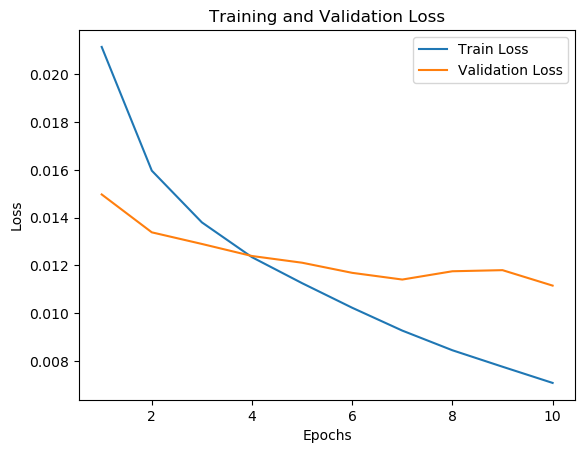

In [11]:
# Plotting Loss
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Ensure the directory exists
model_save_path = './saved_models/AlexNet_cifar10_RejDiff_finetuned.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
torch.save(AlexNet.state_dict(), model_save_path)
print("Model saved as AlexNet_cifar10_RejDiff_finetuned.pth")

Model saved as AlexNet_cifar10_RejDiff_finetuned.pth


In [13]:
AlexNet.load_state_dict(torch.load(model_save_path, weights_only=True))
AlexNet = AlexNet.to(device)

In [14]:
final_val_loss, final_val_accuracy, final_precision, final_recall, final_f1 = validate(AlexNet, testloader)
print(f'\nFinal Test Results - Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.2f}%, Precision: {final_precision:.2f}, Recall: {final_recall:.2f}, F1 Score: {final_f1:.2f}')

100%|███████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 20.11it/s]


Final Test Results - Loss: 0.0112, Accuracy: 87.94%, Precision: 0.88, Recall: 0.88, F1 Score: 0.88
